In [16]:
# pip install langchain_openai

In [17]:
from typing import Annotated
from typing import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
import os
from dotenv import load_dotenv

In [18]:
load_dotenv()

True

In [19]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"


In [20]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001F0D669D240>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001F0EF383130>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [21]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [22]:
@tool
def add(a: float, b: float):
    """Add two numbers"""
    return a+b

tools = [add]
llm_with_tool = llm.bind_tools(tools)

In [23]:
def call_llm_model(state: State) -> State:
    return {"messages": [llm_with_tool.invoke(state['messages'])]}

In [24]:
builder=StateGraph(State)
builder.add_node("tool_calling_llm",call_llm_model)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
# builder.add_edge("tools","tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph=builder.compile()

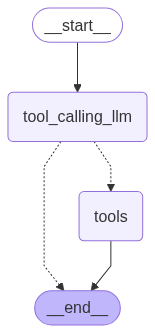

In [25]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
response = graph.invoke({"messages": "What is 7 plus 7"})
response

{'messages': [HumanMessage(content='What is 7 plus 7', additional_kwargs={}, response_metadata={}, id='4683cd19-9409-4ffe-bed8-cc0c4f4b5d8a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'bvwtm693p', 'function': {'arguments': '{"a":7,"b":7}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 72, 'prompt_tokens': 898, 'total_tokens': 970, 'completion_time': 0.05389618, 'prompt_time': 0.161477994, 'queue_time': 0.5899920169999999, 'total_time': 0.215374174}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_5b339000ab', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6cbeb80f-50e8-47af-bc3f-296ba71c1de2-0', tool_calls=[{'name': 'add', 'args': {'a': 7, 'b': 7}, 'id': 'bvwtm693p', 'type': 'tool_call'}], usage_metadata={'input_tokens': 898, 'output_tokens': 72, 'total_tokens': 970}),
  ToolMessage(content='14.0', name='add', id='15dd6da0-d008-41f5-b93b-ae25acf93d44', tool_call_i

In [29]:
response - graph.invoke({"messages": "What is Machine Learning"})
# response

BadRequestError: Error code: 400 - {'error': {'message': "tool call validation failed: attempted to call tool 'explain_machining_learning' which was not request.tools", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n    "tool_calls": [\n        {\n            "id": "pending",\n            "type": "function",\n            "function": {\n                "name": "explain_machining_learning"\n            },\n            "parameters": {\n                "description": "What is Machine Learning"\n            }\n        }\n    ]\n}\n</tool-use>'}}